In [96]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
def tsne_by_gender(vecs, labels, title):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)

  names = ["class 1", "class 2"]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b'
  for i, c, label in zip(range(10), colors, names):
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c, label=label, alpha = 0.2)
  plt.legend()
  plt.title(title)
  plt.show()
  return vecs_2d

### Data loading & processing

In [110]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors):
    
    group1 = model.similar_by_vector(gender_vector, topn = 1500, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = 1500, restrict_vocab=None)
    
    return group1, group2

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [111]:
model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")
model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")
gender_direction = model_gendered["he"] - model_gendered["she"]
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)

#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])

masc_words_and_scores, fem_words_and_scores = project_on_gender_subspaces(gender_direction, model)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)

print(masc_words[:25])
print(masc_words[-10:])
print("-------------------------")
print(fem_words[:25])
print(fem_words[-10:])

('journeyman', 'elder_statesman', 'fellow_countryman', 'endeared_himself', 'cult_hero', 'journeymen', 'swashbuckling', 'distanced_himself', 'prodigal_son', 'tradeable', 'prides_himself', 'hero', 'heir_apparent', 'elder_statesmen', 'benching', 'successor', 'burly', 'serviceable', 'jnr', 'goatee', 'league', 'training_camp', 'maestro', 'legendary', 'positional')
('revert', 'prorated', 'engineer', 'gamer', 'alignments', 'gut_feeling', 'helm', 'prognostications', 'whiz_kid', 'offseason')
-------------------------
('alumna', 'beautician', 'motherly', 'petite', 'comedienne', 'saleswoman', 'songstress', 'ditzy', 'mommies', 'lip_gloss', 'perky', 'girlish', 'homemaker', 'bra', 'femininity', 'chanteuse', 'mums', 'pregnant', 'vivacious', 'breastfeeding', 'registered_nurse', 'catty', 'seamstress', 'tiara', 'spinster')
('fashionably', 'districtwide', 'pubic_hair', 'intern', 'gluten_free', 'scarves', 'scents', 'chastity', 'ear_infections', 'preterm_birth')


### Perform train-dev-test split

In [113]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
y_masc = np.zeros(masc_vecs.shape[0], dtype = int)
y_fem = np.ones(fem_vecs.shape[0], dtype = int)
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 1260; Dev size: 540; Test size: 1200


### Debias

In [114]:
classifier_class = svm_classifier.SVMClassifier
num_classifiers = 40
input_dim = 300
is_autoregressive = True
min_accuracy = 0.5
add_noise = False
random_projection = False

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_projection)

Iteration 0, Accuracy: 1.0
Iteration 1, Accuracy: 0.8907407407407407
Iteration 2, Accuracy: 0.8722222222222222
Iteration 3, Accuracy: 0.8185185185185185
Iteration 4, Accuracy: 0.7851851851851852
Iteration 5, Accuracy: 0.7166666666666667
Iteration 6, Accuracy: 0.6796296296296296
Iteration 7, Accuracy: 0.6666666666666666
Iteration 8, Accuracy: 0.6425925925925926
Iteration 9, Accuracy: 0.587037037037037
Iteration 10, Accuracy: 0.5851851851851851
Iteration 11, Accuracy: 0.5833333333333334
Iteration 12, Accuracy: 0.5537037037037037
Iteration 13, Accuracy: 0.5481481481481482
Iteration 14, Accuracy: 0.5462962962962963
Iteration 15, Accuracy: 0.5537037037037037
Iteration 16, Accuracy: 0.5722222222222222
Iteration 17, Accuracy: 0.5666666666666667
Iteration 18, Accuracy: 0.5574074074074075
Iteration 19, Accuracy: 0.5722222222222222
Iteration 20, Accuracy: 0.5648148148148148
Iteration 21, Accuracy: 0.5444444444444444
Iteration 22, Accuracy: 0.5574074074074075
Iteration 23, Accuracy: 0.55555555555

### Test the quality of the debiasing.

#### Perform t-sne

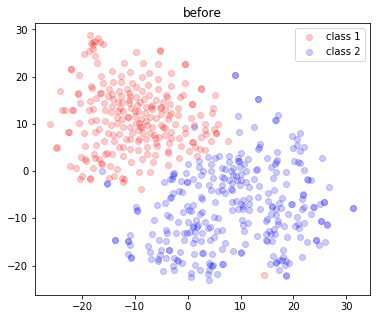

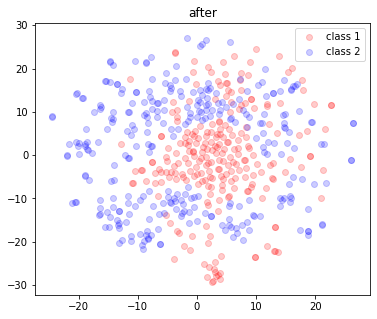

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

Purity in original space: 0.9137931913066313
Purity after debiasing projection: 0.6473528143833963


In [115]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score


tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

NUM_CLUSTERS = 100

purity_original = perform_purity_test(X_dev, k = NUM_CLUSTERS, labels_true = Y_dev)
purity_after = perform_purity_test(X_dev_cleaned, k = NUM_CLUSTERS, labels_true = Y_dev)
print("Purity in original space: {}".format(purity_original))
print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [116]:
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0
After:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5518518518518518


#### project on the gender direction

In [117]:

masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec).mean()))      

masc-bias-before: 0.4433515667915344
masc-bias-after: -0.017375008980527108
fem-bias-before: -0.7783566117286682
fem-bias-after: -0.02409004209297594


#### calculate the similarity matrix before and after

In [131]:

def get_similarity_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_similarity(similarity_before, similarity_after):

    idx = similarity_before > 0.5 # we are only interested in the relatively close words

    similarity_before = similarity_before[idx]
    similarity_after = similarity_after[idx]
    
    chosen = np.random.rand(len(similarity_after)) < 0.01
    before = similarity_before[chosen]
    after = similarity_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("similarity before")
    plt.ylabel("similarity after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, similarity_before, similarity_after):

    K = 250
    most_similar_idx_before = similarity_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = similarity_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, sim_before, sim_after) in enumerate(tqdm.tqdm(zip(bias_before, similarity_before, similarity_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        
    plt.xlabel("change in similarity")
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

In [ ]:
prop = 0.25
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

similarity_before = get_similarity_matrix(vecs_sample)
similarity_after = get_similarity_matrix(vecs_sample_cleaned)
#diffs = abs(similarity_before - similarity_after)


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sample_cleaned_normalized.dot(gender_unit_vec)

plot_similarity(similarity_before.reshape(-1), similarity_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, similarity_before, similarity_after)


In [213]:
all_cleaned = vecs.dot(P)
save_in_word2vec_format(all_cleaned, words, "../data/embeddings/vecs.cleaned.txt")

50000it [00:12, 3996.29it/s]


In [214]:
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.cleaned.txt")
print
(model_cleaned)

In [241]:
w = "journeyman"
topn = 15

for w_sim in model.most_similar(w, topn = topn):
    print(w_sim)
print("--------------------------------")
for w_sim in model_cleaned.most_similar(w, topn = topn):
    print(w_sim)
    
for w_sim in ['alumna', 'comedienne', 'beautician', 'femininity', 'chanteuse', 'petite', 'songstress', 'girlish', 'saleswoman', 'homemaker', 'showgirl', 'lipsticks', 'ditzy', 'demure', 'bra', 'lip_gloss', 'vivacious', 'hysterectomy', 'perky', 'femme_fatale', 'double_mastectomy', 'spinster', 'registered_nurse', 'sassy', 'motherly']:
    print(model.similarity(w, w_sim) -  model_cleaned.similarity(w, w_sim)) 
print("------------------------------------------")
for w_sim in ['journeyman', 'elder_statesman', 'fellow_countryman', 'journeymen', 'cult_hero', 'wizard', 'knucklehead', 'prodigal_son', 'guys', 'buddy']:
    print(model.similarity(w, w_sim) -  model_cleaned.similarity(w, w_sim)) 

('journeymen', 0.6964870095252991)
('unheralded', 0.5721666216850281)
('rookie', 0.5694584846496582)
('veteran', 0.5209348201751709)
('southpaw', 0.5050339102745056)
('late_bloomer', 0.49564164876937866)
('battler', 0.4772130250930786)
('superstar', 0.47606101632118225)
('pugilist', 0.4711742401123047)
('prodigy', 0.46894553303718567)
('oft_injured', 0.46728408336639404)
('phenom', 0.46141740679740906)
('amateur', 0.45797866582870483)
('undrafted', 0.45401644706726074)
('hotshot', 0.4525316059589386)
--------------------------------
('journeymen', 0.6639416813850403)
('unheralded', 0.5450689792633057)
('rookie', 0.5335802435874939)
('late_bloomer', 0.49659085273742676)
('southpaw', 0.48855212330818176)
('veteran', 0.47595036029815674)
('battler', 0.4619813561439514)
('pugilist', 0.4618586003780365)
('phenom', 0.4598551392555237)
('prodigy', 0.4582870602607727)
('superstar', 0.4562338888645172)
('amateur', 0.4561074376106262)
('cruiserweight', 0.4459923803806305)
('middleweight', 0.4457

In [264]:
most_similar_idx_before = similarity_before.argsort(axis = 0)[:15]
most_similar_idx_after = similarity_after.argsort(axis = 0)[:15]

In [265]:
print(words_sample[:1000])

print(most_similar_idx_before.shape,most_similar_idx_after.shape)
i = words_sample.tolist().index("face")

for k in range(15):
    
    before = words_sample[most_similar_idx_before[k,i]]
    after = words_sample[most_similar_idx_after[k,i]]
    print(before, after)

['is' 'on' 'was' 'be' 'by' 'are' 'have' 'this' 'had' 'up' 'do' 'new'
 'people' 'three' 'no' 'did' 'back' 'now' 'against' 'off' 'state' 'good'
 'four' 'such' 'very' 'even' 'see' 'me' 'help' 'market' 'information'
 'part' 'want' 'need' 'same' 'set' 'city' 'am' 'better' 'life' 'show'
 'past' 'took' 'children' 'hit' 'area' 'system' 'members' 'start'
 'companies' 'little' 'case' 'won' 'financial' 'several' 'held' 'later'
 'full' 'community' 'open' 'record' 'able' 'meeting' 'development' 'times'
 'job' 'always' 'include' 'important' 'within' 'move' 'become' 'side'
 'coach' 'near' 'getting' 'change' 'prices' 'asked' 'done' 'leading'
 'having' 'military' 'oil' 'customers' 'due' 'term' 'international'
 'return' 'further' 'face' 'hours' 'control' 'career' 'experience'
 'countries' 'average' 'cut' 'young' 'story' 'per_cent' 'large' 'stock'
 'food' 'morning' 'conference' 'person' 'official' 'released' 'meet'
 'outside' 'fact' 'needed' 'almost' 'try' 'visit' 'bring' 'study' 'care'
 'markets' 'weeke